**HOW MUCH DOES AGE AND PLAYED HOURS INFLUENCE SUBSCRIPTION RATE?**

In [15]:
library(tidyverse)
library(tidymodels)

**Introduction**:

Our data originates from a research group from the Computer Science department at UBC investigating how different individuals play video games. We have acquired data from a MineCraft server, where players’ actions were recorded as they explored a new world. Our task is to assist the research group in recruitment efforts and resource (software licenses and server hardware) management to boost individuals’ gaming experience/satisfaction and accommodate the number of players the system receives.

We have been given two datasets: players.csv and sessions.csv. The players.csv dataset focuses on each individual’s characteristics, including name, gender, and age, while the sessions.csv data set targets each specific gaming session and its duration. We have chosen to explore the players.csv, as we believe the variables are more predictive and have greater effectiveness in aiding our goals. The players.csv dataset is described in the following table below, with possible issues in data highlighted in its own column:

#### 'players.csv' File: 196 Observations, 7 Variables
|Variable|Type|Description|Issues in Data|
|--------|----|-----------|----------------|
|experience|Character|Individual's gaming experience (Beginner, Amateur, Regular, Pro, or Veteran)|This variable can be rearranged within the dataset for better readability|
|subscribe|Logical|Whether or not they have subscribed to a game-related newsletter|No potential issues|
|hashedEmail|Character|Individual's hashed email identifier|Unneeded for data analysis|
|played_hours|Double|Number of hours they have played the video game|Some values indicate 0 (inactive players), which should be removed from the dataset|
|name|Character|Individual's name|Unneeded for data analysis|
|gender|Character|Individual's gender|Possible missing values (or 'Prefer not to say'), which should be removed from the dataset|
|Age|Double|Individual's age|Possible missing values (i.e., 'NA'), which should be removed from the dataset|


This dataset includes 196 observations regarding 7 variables including an individual’s gaming experience (Beginner, Amateur, Regular, Pro, or Veteran), whether or not they have subscribed to a game-related newspaper, their hashed email, the number of hours they have played on the MineCraft server, their name, their gender, and their age. 


However, not all of these variables are useful or properly formatted for our data analysis. For example, the ‘gender’ and ‘age’ variables have missing or uninformative values (i.e., ‘Prefer not to say’ or ‘NA’), which can be removed. Moreover, several variables have incorrect data types, which must be changed. This includes the age, experience, and gender variables, which can be modified into numeric, factor, and factor, respectively. Additionally, for easier coding, we could rename the variable, ‘Age,’ so it is in lowercase like the other variables.

As our preliminary goal is to aid the research group’s recruitment efforts to accommodate for the large number of players, the overarching question we will attempt to tackle is presented below. 


**Question 1:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

We have chosen this question because we believe that players who subscribe to the game-related newsletter are more likely to spend longer hours playing the game, which thus increases the amount of data the research group acquires. By predicting which variables are most likely to predict player subscription rates, the research group can delegate more resources to this population. Furthermore, to better answer this question and effectively explore the dataset, we have selected a sub-question to aid our analysis efforts.

**Sub-Question:** Are player age and played hours influential variables that predict subscription rate?


We believe this question answers our overarching question as our exploratory variables are the individual’s age and number of played hours, which we hope will be the main variables within the dataset that can predict whether an individual subscribes to the gaming newsletter. 
By determining that these variables can influence subscription rates, we can then aim to explore whether younger/older players or how long they spend on the MineCraft server influence their subscription rates in the future. If there is a trend, resources may be prioritized for individuals with these behaviours to maximize subscription rates.


**METHOD AND RESULTS**

For this project, the subscription rate is predicted based on player age and played hours. 
A new data set is created by selecting the necessary columns and standardizing it to make the average is 0 and the standard deviation is 1. The training and testing sets are separated with a ratio of 3:1 from the new data set. The prediction follows the process of making a recipe, building a model specification, putting the recipe and specification together into a workflow, fitting in the data, and predicting it. 


To select the best K, only the training set is used at this stage. The training set is further split into 10 equal-sized chunks by the strategy called 10-fold cross-validation. Then, 1 chunk is used as the validation set, the subset of the training set that is used for evaluation, and the rest of the chunks are the training set. Thus, there are multiple combinations. We choose K from sequence 1 to 100 stepping by 5. Fitting the cross-validation and the sequence into the workflow will calculate each training/validation split. Mean and standard errors will be calculated. Means are used to be estimated accuracies and standard errors are the uncertainty we have in the value of mean. We collect the mean values in descending order and choose the K with the highest mean. The graph is also given to see the trend of change of accuracy by changing different choices of K. 


With the best K, the same process is preceded by fitting the original training set into the workflow instead of cross-validation and using the workflow to predict based on the testing set.  Finally, the accuracy rate can be calculated by the number of correct predictions over the number of total predictions.


In [16]:
player_data <- "https://raw.githubusercontent.com/rinhatan/dsci100_project/refs/heads/main/players.csv"
players <- read_csv(player_data)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [17]:
player_whole <- players |>
            select(played_hours, Age, subscribe) |>
            mutate(subscribe = as_factor(subscribe)) |>
            mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))

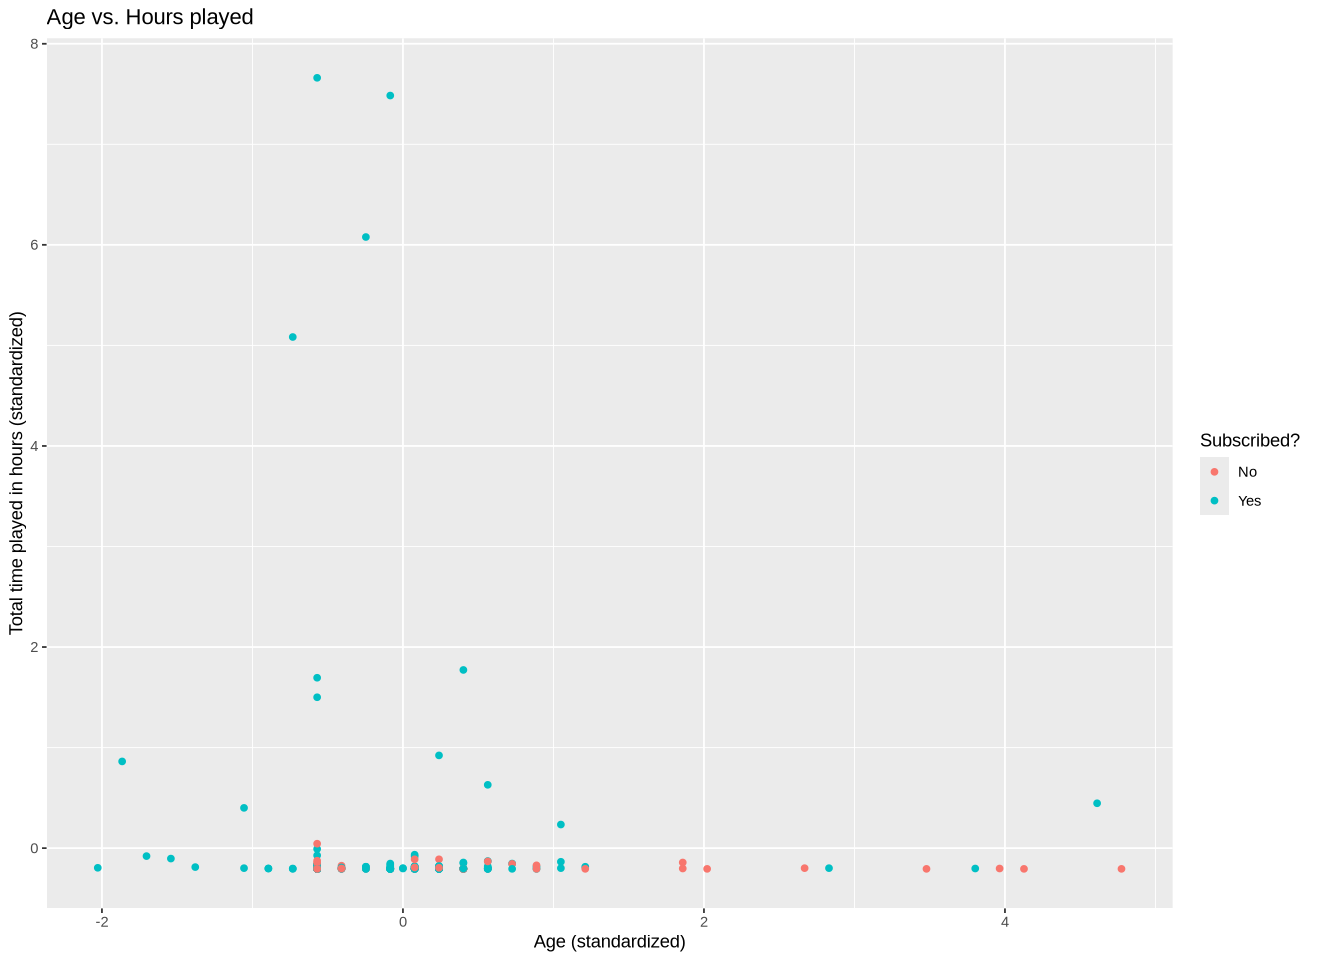

In [18]:
players_first_recipe <- recipe(subscribe ~ Age + played_hours, data = player_whole) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors()) |>
    prep()
scaled_players <- bake(players_first_recipe, player_whole)

player_summary <- scaled_players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = "Age (standardized)", y = "Total time played in hours (standardized)", color = "Subscribed?") +
    ggtitle("Age vs. Hours played")
player_summary

In the standardized visualization, we are able to observe that those who had greater played hours had subscribe to the game. Furthermore, it can be seen that younger players tended to subscribe to more as there are more clumps of blue when the age is smaller, while when the age value become greater, there are less subscribed players (though there are also less older people that participated in this study).

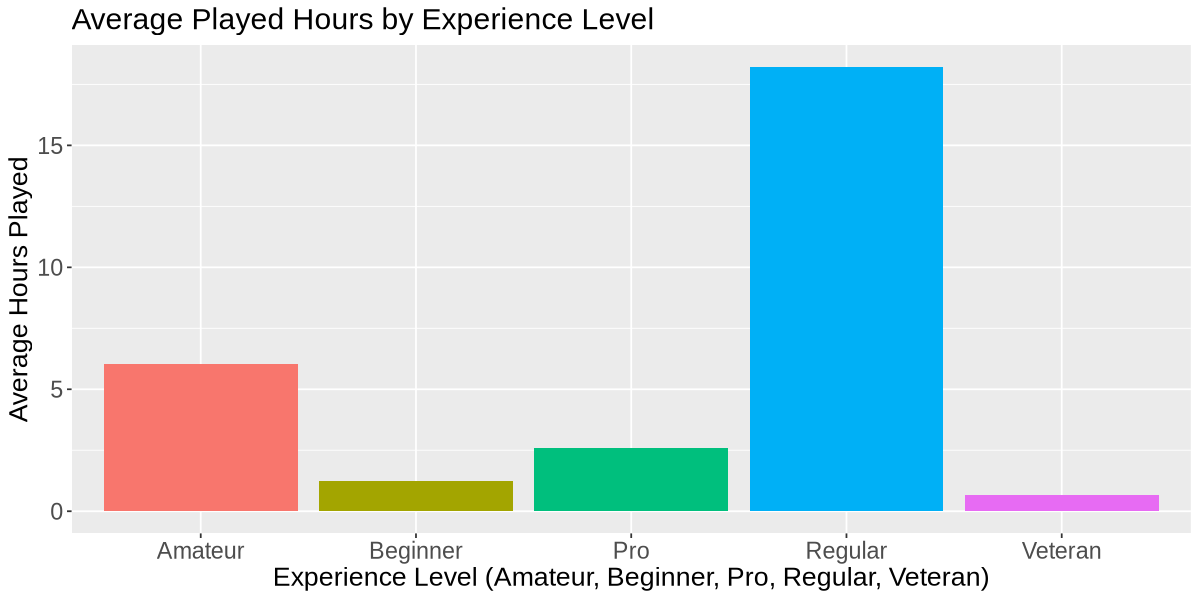

In [24]:
options(repr.plot.width = 10, repr.plot.height = 5)

players_experience <- players |>
  group_by(experience) |>
  summarise(avg_played_hours = mean(played_hours, na.rm = TRUE))

experience_avg_hours_plot <- players_experience |>
        ggplot(aes(x = experience, y = avg_played_hours, fill = experience)) +
        geom_bar(stat = "identity") + 
        labs(title = "Average Played Hours by Experience Level", x = "Experience Level (Amateur, Beginner, Pro, Regular, Veteran)", y = "Average Hours Played")+
        theme(legend.position = "none", axis.title = element_text(size = 16), plot.title = element_text(size = 18), axis.text = element_text(size = 14))

experience_avg_hours_plot

A bar graph of the relationship between experience level (amateur, beginner, pro, regular, veteran) against average hours played. The graph shows that the ‘regular’ skilled individuals have played the most hours.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


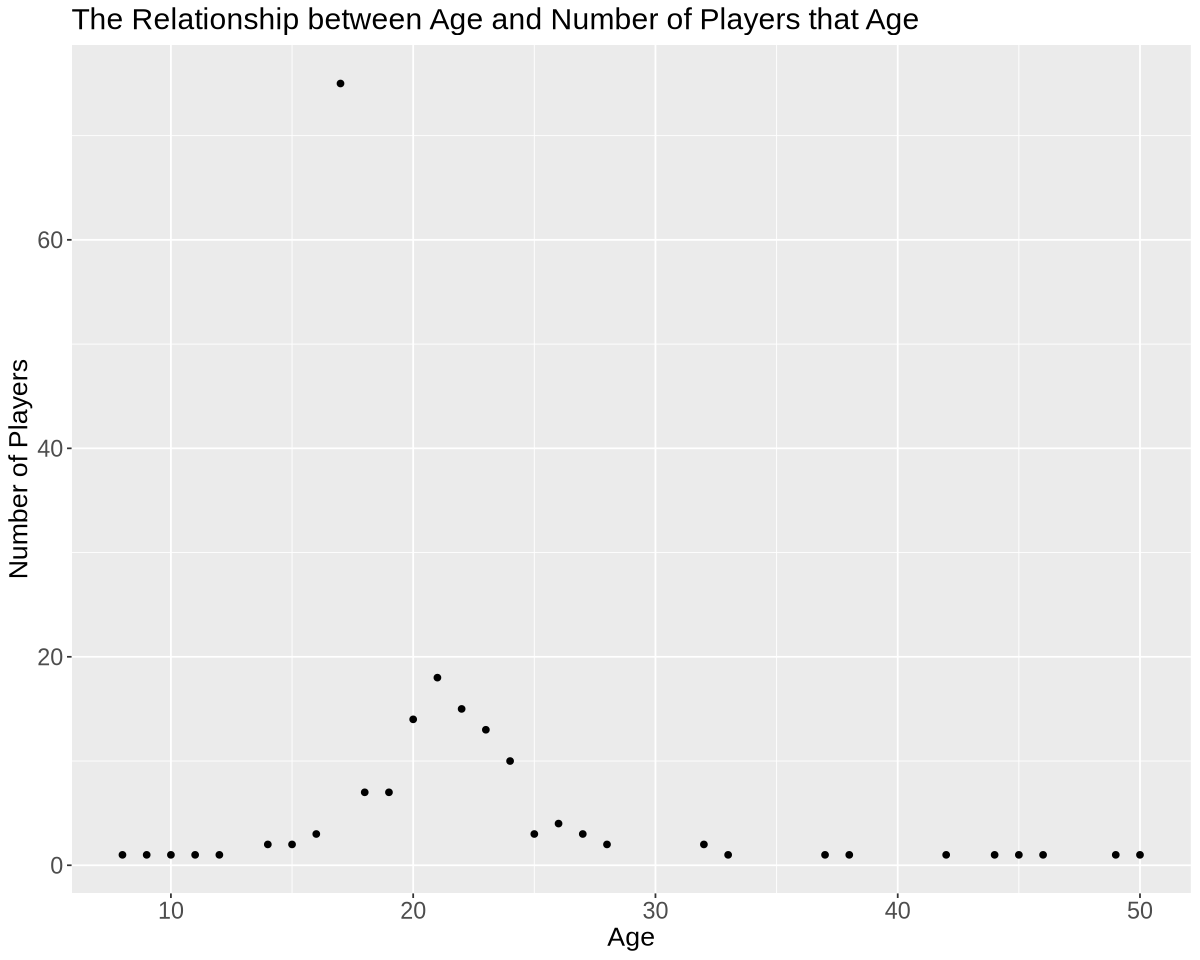

In [23]:
number_of_players_by_age <- players |>
    group_by(Age) |>
    summarise(num_players = n())

options(repr.plot.width = 10, repr.plot.height = 8)

age_number_of_players_by_age_plot <- number_of_players_by_age |>
        ggplot(aes(x = Age, y = num_players))+
        geom_point() +
        labs(title = "The Relationship between Age and Number of Players that Age", x = "Age", y = "Number of Players")+
        theme(axis.title = element_text(size = 16), plot.title = element_text(size = 18), axis.text = element_text(size = 14))
age_number_of_players_by_age_plot


A scatterplot of the relationship between age and number of players. The age is skewed left (most players are 15-25 years old) and there is a large spike in the number of 17 year old players.

**DATA ANALYSIS:**

In [45]:
set.seed(1)
player_split <- initial_split(player_whole, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

**For analyzing the data accuracy of Age:**

[1] 31

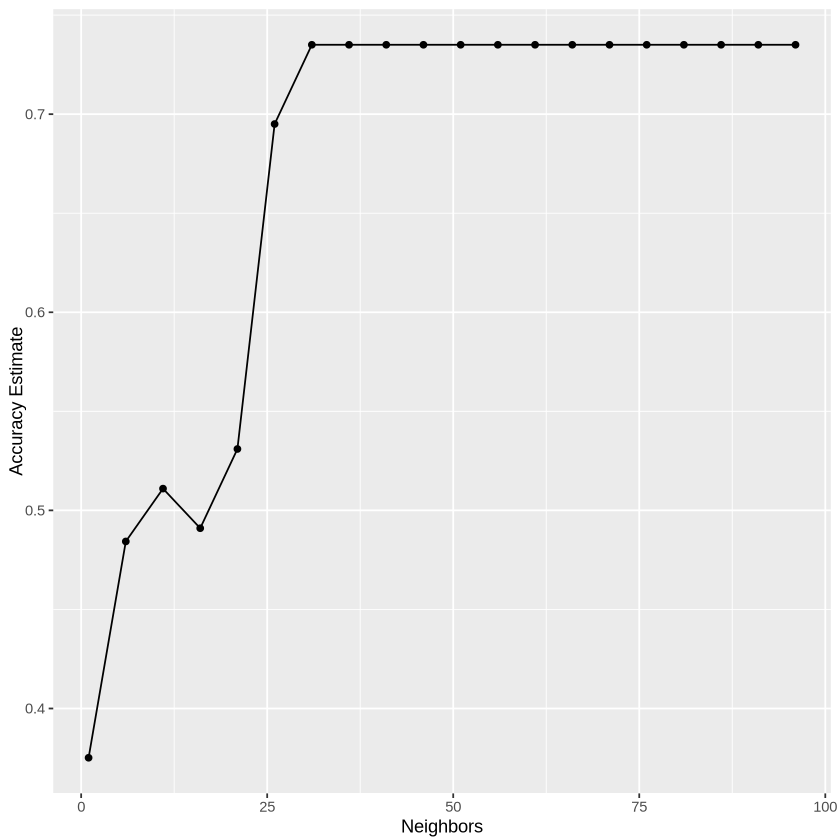

In [108]:
k_vals_age <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

player_vfold_age <- vfold_cv(player_train, v = 10, strata = subscribe)

knn_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")

player_recipe_age <- recipe(subscribe ~ Age, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

knn_results_age <- workflow() |>
    add_recipe(player_recipe_age) |>
    add_model(knn_spec_age) |>
    tune_grid(resamples = player_vfold_age, grid = k_vals_age) |>
    collect_metrics()

accuracy_find_age <- knn_results_age |>
    filter(.metric == "accuracy")

accuracy_vs_k_lots_age <- ggplot(accuracy_find_age, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

best_k_age <- accuracy_find_age |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k_age
accuracy_vs_k_lots_age

In [113]:
player_recipe_2 <- recipe(subscribe ~ Age, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_2 <- workflow() |>
    add_recipe(player_recipe_2) |>
    add_model(knn_spec_2) |>
    fit(data = player_train)

player_test_predictions_age <- predict(knn_fit_2, player_test) |>
    bind_cols(player_test)

player_test_accuracy_age <- player_test_predictions_age |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_test_accuracy_age

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


**For analyzing the data accuracy of played hours:**

[1] 51

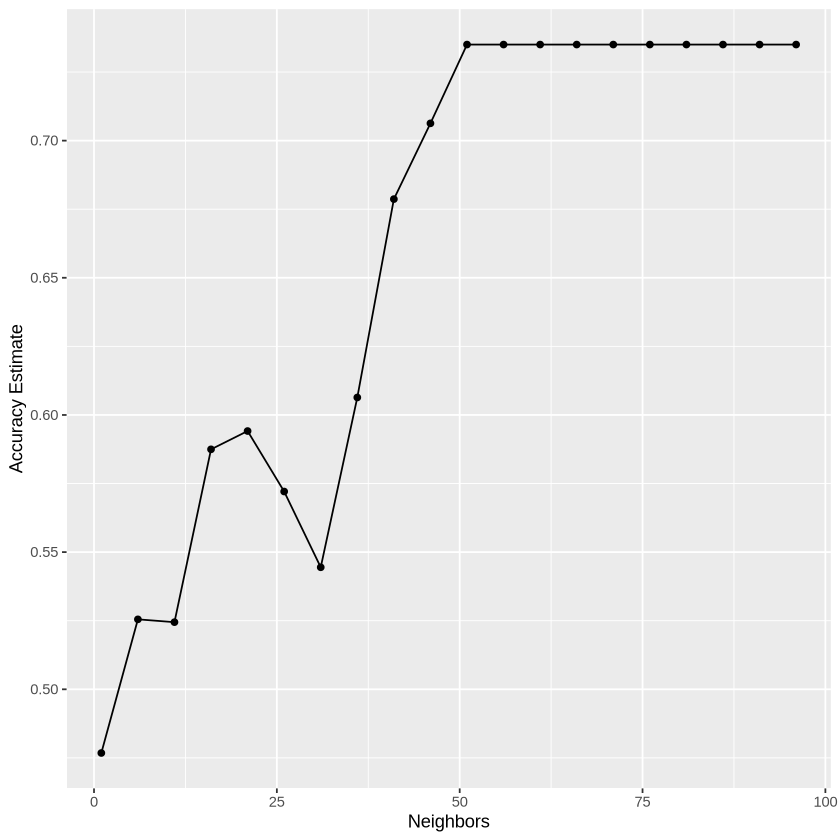

In [83]:
k_vals_hours <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

player_vfold_hours <- vfold_cv(player_train, v = 10, strata = subscribe)

knn_spec_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")

player_recipe_hours <- recipe(subscribe ~ played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

knn_results_hours <- workflow() |>
    add_recipe(player_recipe_hours) |>
    add_model(knn_spec_hours) |>
    tune_grid(resamples = player_vfold_hours, grid = k_vals_hours) |>
    collect_metrics()

accuracy_find_hours <- knn_results_hours |>
    filter(.metric == "accuracy")

accuracy_vs_k_lots_hours <- ggplot(accuracy_find_hours, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

best_k_hours <- accuracy_find_hours |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k_hours
accuracy_vs_k_lots_hours

In [89]:
player_recipe_3 <- recipe(subscribe ~ played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_hours) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_3 <- workflow() |>
    add_recipe(player_recipe_3) |>
    add_model(knn_spec_3) |>
    fit(data = player_train)

player_test_predictions_hours <- predict(knn_fit_3, player_test) |>
    bind_cols(player_test)

player_test_accuracy_hours <- player_test_predictions_hours |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_test_accuracy_hours

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5510204


**For both played hours and age:**

[1] 21

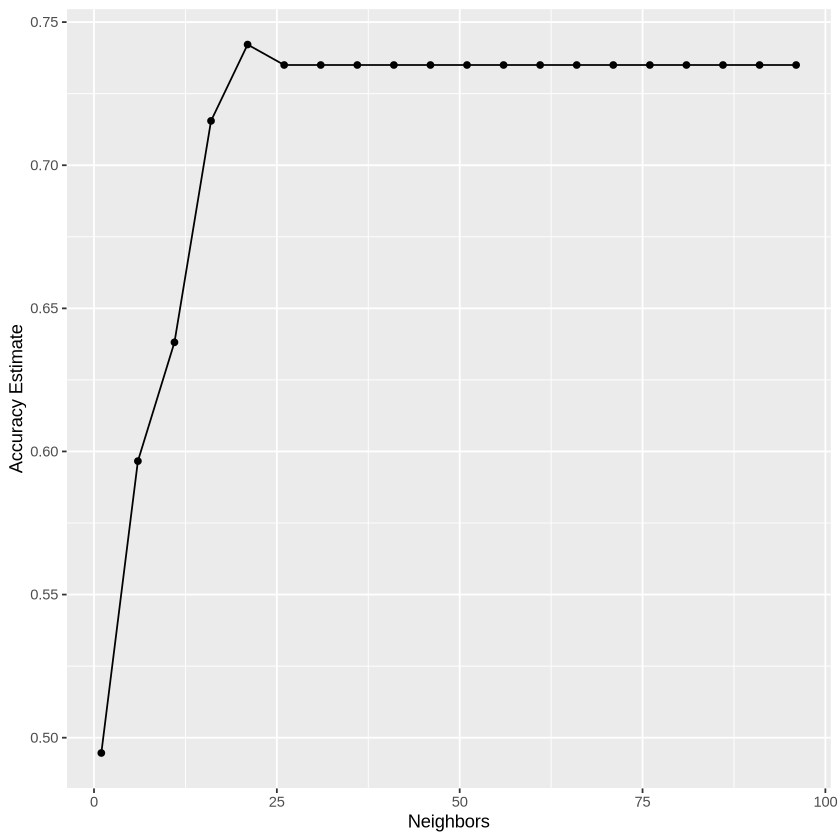

In [110]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

player_vfold <- vfold_cv(player_train, v = 10, strata = subscribe)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")

player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

knn_results <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

accuracy_find <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k_lots <- ggplot(accuracy_find, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

best_k <- accuracy_find |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k
accuracy_vs_k_lots

In [111]:
player_recipe_2 <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_2 <- workflow() |>
    add_recipe(player_recipe_2) |>
    add_model(knn_spec_2) |>
    fit(data = player_train)

player_test_predictions <- predict(knn_fit_2, player_test) |>
    bind_cols(player_test)

player_test_accuracy <- player_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


**Overall, the results were:**

In [114]:
player_test_accuracy_age
player_test_accuracy_hours
player_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5510204


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


New names:
• `` -> `...5`


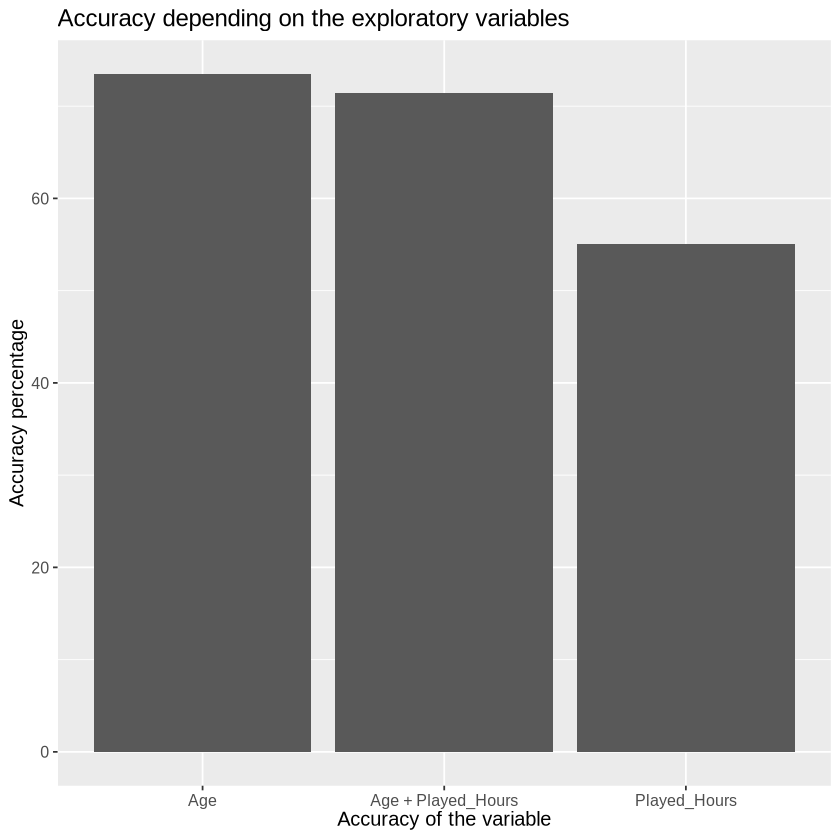

In [130]:
types <- c("Age", "Played_Hours", "Age + Played_Hours")
final_table <- bind_rows(player_test_accuracy_age, player_test_accuracy_hours, player_test_accuracy) |>
            mutate(accuracy = .estimate * 100) |>
            bind_cols(types) |>
            rename(Accuracy_Types = ...5)
            
final_plot <- ggplot(final_table, aes(x = Accuracy_Types, y = accuracy)) +
            geom_bar(stat = "identity") +
            labs(x = "Accuracy of the variable", y = "Accuracy percentage") +
            theme(text = element_text(size = 12)) +
            ggtitle("Accuracy depending on the exploratory variables")
final_plot

**DISCUSSION**

**Summary of What We Found:**

In the data analysis, we can observe that age has the highest accuracy in predicting the subscription rate as it has the highest accuracy percentage of 73%. The explanatory variable that had lower accuracy was 55%. When the classifier was trained to predict with both age and played_hours as explanatory variables, it can be observed in the data analysis that the accuracy decreased to 71%. From this, we can still not trust the classifier as a 73% accuracy rate is still quite low. While we still split the data and train the classifier in a separate model to apply on the testing data, more data may be beneficial to determine a more precise accuracy. Additionally, since the data was developed by filling in the NA observations with the mean of other observations, we had not tested the model on a completely trustworthy and accurate data frame to begin with. 


A key factor that impacted the model’s reliability was the relatively small sample size and lack of feature richness limited the ability to create a robust and generalizable model. This moderate model accuracy suggests some underlying signal in the features. 


Ultimately, it was observed that age had the strongest correlation with subscription, and more complex models or additional variables did not necessarily improve performance. This points to the need for better data quality, more features, or more robust modelling to obtain meaningful results. 


**Our expectations:**

These findings significantly diverged from our initial expectations. Going into the analysis, we hypothesized that played_hours would be the strongest predictor or subscription rate. This seemed logical: if a user is spending more time playing a game, they are likely enjoying it, and therefore inclined to subscribe for additional content, perks, or features. We expected that time investment would reflect engagement and future intent. 
However, the data analysis revealed the opposite. Age had a higher predictive value, and played_hours was surprisingly weak as a standalone feature. Even more unexpected was the finding that combining age with played_hours slightly reduced accuracy, implying that played_hours either added noise or was potentially correlated with age in a way that didn’t benefit the model.


The discrepancy between hypothesis and outcome highlights the complexity of user behaviour. It’s possible that users who play more hours are already satisfied with the free content or that playtime doesn’t necessarily translate to a willingness to pay. On the other hand, younger users might spend more time playing but lack financial independence, while older users may subscribe quickly without needing prolonged engagement to decide. 
Another initial expectation we had was that more features would always help, following the assumption that increased data leads to better insights. The outcome contradicted that notion, as it emphasized the importance of feature quality over quantity. This result means that machine learning models don’t just need more data, they need the right data.


The results show the complexity of user behaviour and how it doesn’t always align with our assumptions, and how simple metrics, like total hours played, may not capture the full picture of user intent or value.


**The impact of our findings:**

There are several potential implications these findings may have, especially in how games are marketed, monetized, and analyzed.


For one, marketing strategies can be influenced. The fact that age outperformed played-hours in predicting subscriptions can directly inform targeted advertising and potential strategies. If older users are more likely to subscribe, marketing campaigns could prioritize these demographics through age-focused content, email, targeting, or proportional bundles designed for that audience. 


The findings can also impact user segmentation and personalization. The data analysis suggests that user profiles should not only consider play behaviour, but also demographic factors like age. Personalized experiences could be adapted to cater to users in different age brackets, improving both user satisfaction and revenue potential. 
On a higher level, these findings may also impact business and product strategy. Companies might re-evaluate how they define and track user engagement. Relying on surface-level data factors like total played hours may not be sufficient. Instead, companies may need to collect and consider richer behavioral or contextual data (e.g., how users interact with in-game content, how long they’ve been using the platform, or what kind of devices they use). 


Lastly, model development and data handling can be influenced. The drop in accuracy when combining features shows that blindly stacking variables into a model can backfire. This encourages a more deliberate approach to feature selection and model building, where each variable must be justified and evaluated for its contribution. Also, since we relied on mean imputation for missing values, these results indicate how critical clean and representative data is for making reliable predictions. 


**Future questions:**

Branching into the future, these findings open several new questions:
- Could alternative models produce better accuracy?
- If we expand or segment the data (e.g., focusing on older demographics), how would that Impact prediction?
- Would using more precise engagement metrics, beyond just total hours played, improve accuracy?
- How would the model perform with cleaner or larger datasets where no values had to be imputed?
